In [1]:
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack

# Number of sample points
N = 1024
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)

w1 = 2 * np.pi * 80
w2 = 2 * np.pi * 125
w3 = 2 * np.pi * 400
y = np.sin(w1*x) + 0.5*np.sin(w2*x) + 0.3*np.cos(w3*x)

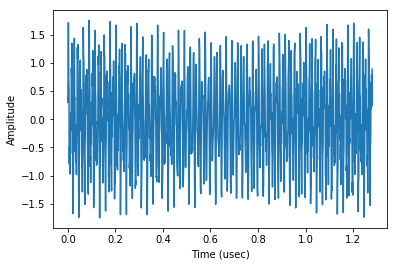

In [2]:
plt.plot(x, y)
plt.xlabel('Time (usec)')
plt.ylabel('Amplitude')
plt.show()

In [3]:
import time

start_time = time.time()
sw_output = scipy.fftpack.fft(y)
end_time = time.time()
sw_time = end_time - start_time
print(f"Software Time: {sw_time}")

xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

Software Time: 0.0014166831970214844


/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


In [4]:
type(sw_output[0])

numpy.complex128

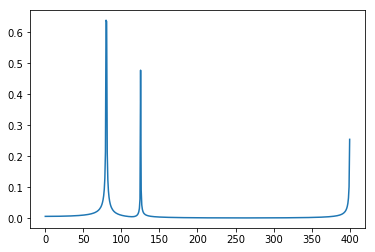

In [5]:
fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(sw_output[:N//2]))
plt.show()

In [6]:
from pynq import Overlay

overlay = Overlay(f"./1024_point_fft.bit")

In [7]:
overlay?

In [8]:
import pynq.lib.dma

fft_ip = overlay.fft_0

In [9]:
import numpy as np
from pynq import allocate
from random import randint

length = 1024
real_buffer = allocate(shape=(length,), dtype=np.float32)
img_buffer = allocate(shape=(length,), dtype=np.float32)

real_samples = y
img_samples = [0]*1024

In [10]:
# Original Input (in float32)
print(f"Real Input: {real_samples[:10]}")
print(f"Imaginary Input: {img_samples[:10]}")

Real Input: [ 0.3         0.70428465  1.7130014   0.74663115  0.53086531 -0.79295453
 -0.47949222 -0.97173536 -0.14963194 -0.60900562]
Imaginary Input: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
np.copyto(real_buffer, real_samples)
np.copyto(img_buffer, img_samples)

In [12]:
fft_ip.write(0x10, real_buffer.physical_address)
fft_ip.write(0x18, img_buffer.physical_address)

# running the IP
start_time = time.time()

fft_ip.write(0x00, 0x1)

# wait until the ap_idle bit is 1
while(fft_ip.read(0x00) & 0x4 == 0):
    pass

end_time = time.time()
hw_time = end_time - start_time
print(f"Hardware Time: {hw_time}")

Hardware Time: 0.017809391021728516


In [13]:
real_output = np.array([0]*1024, dtype=np.float32)
img_output = np.array([0]*1024, dtype=np.float32)

np.copyto(real_output, real_buffer)
np.copyto(img_output, img_buffer)

In [14]:
print(f"Real Output: {real_output}")
print(f"Imaginary Output: {img_output}")

Real Output: [3.3747823 3.3750887 3.3760242 ... 3.3774657 3.3758435 3.374633 ]
Imaginary Output: [ 0.         -0.00193787 -0.00387383 ...  0.00578308  0.00384712
  0.00190735]


In [15]:
# generate a complex array by combining the real and imaginary part
ip_output = real_output + 1j*img_output

In [16]:
# print the complex numpy array
ip_output

array([3.3747823+0.j        , 3.3750887-0.00193787j,
       3.3760242-0.00387383j, ..., 3.3774657+0.00578308j,
       3.3758435+0.00384712j, 3.374633 +0.00190735j], dtype=complex64)

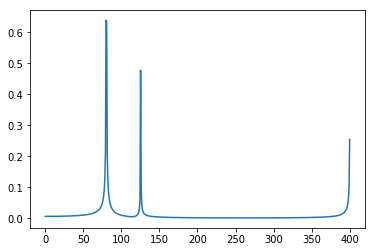

In [17]:
# plot the constituent frequencies
fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(ip_output[:N//2]))
plt.show()

In [18]:
threshold = [0.1, 0.01]

print("0.1% Error Margin \t 0.01% Error Margin")
for j in range(len(threshold)):
    error_count = [0, 0]
    for i in range(length):
        if y[i] != 0 + 0j:
            error_margin =  ( sw_output[i] - ip_output[i] ) / sw_output[i]
            error_margin = np.abs(error_margin)
        else:
            error_margin =  ( sw_output[i] - ip_output[i] ) / (0.001 + 0.001j)
            error_margin = np.abs(error_margin)
        if error_margin*100 > threshold[j]:
                error_count[j] += 1
            # print(f"Error: {error_margin}")
            # print(f"{sw_output[k][i]} =/= {ip_output[k][i]}\n")
print(f"{error_count[0]} \t\t\t {error_count[1]}")

0.1% Error Margin 	 0.01% Error Margin
0 			 17


In [19]:
speed_factor = ( (sw_time)/hw_time) * 100

print(f"FFT Speed decreased by {speed_factor}!")

FFT Speed decreased by 7.954697582264586!
